# 8 マルコフ連鎖モンテカルロ(MCMC)法とベイズ統計モデル

[データ解析のための統計モデリング入門8章](http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html)  

担当 hagino3000  

前半
- (効率のよくない)試行錯誤による最尤推定法を紹介する
- それをMCMCアルゴリズムに改造し、MCMCサンプリングをする

## 8. 1 例題：種子の生存確率(個体差なし)

20個体の生存種子数は

In [1]:
y = [4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4]

とする。このデータをヒストグラムで図示すると

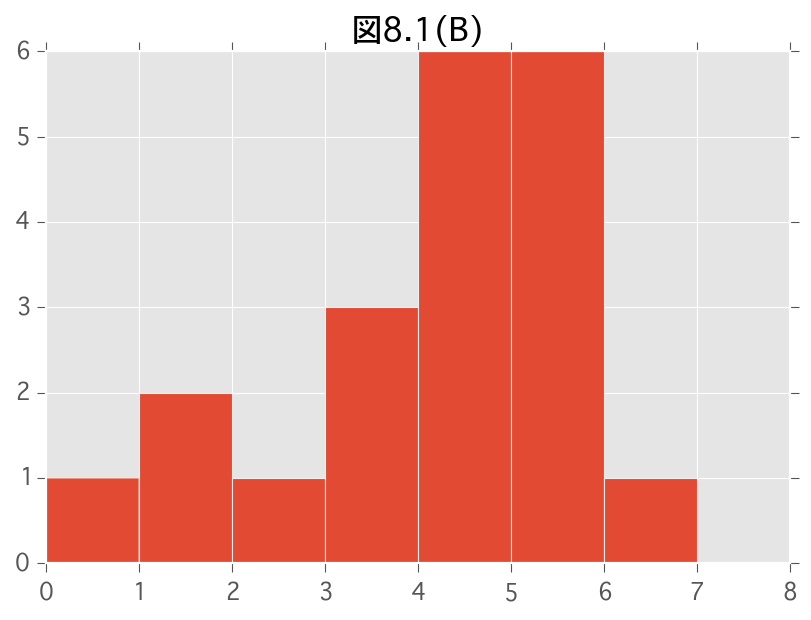

In [2]:
plt.hist(y, bins=range(9))
_ = plt.title(u'図8.1(B)')

過分散ではないようなので、生存種子数$yi$が二項分布に従うと仮定する。

In [3]:
import scipy.misc

In [4]:
def p_y_given_q(q, y):
    return scipy.misc.comb(8, y) * (q**y) * (1-q)**(8-y)

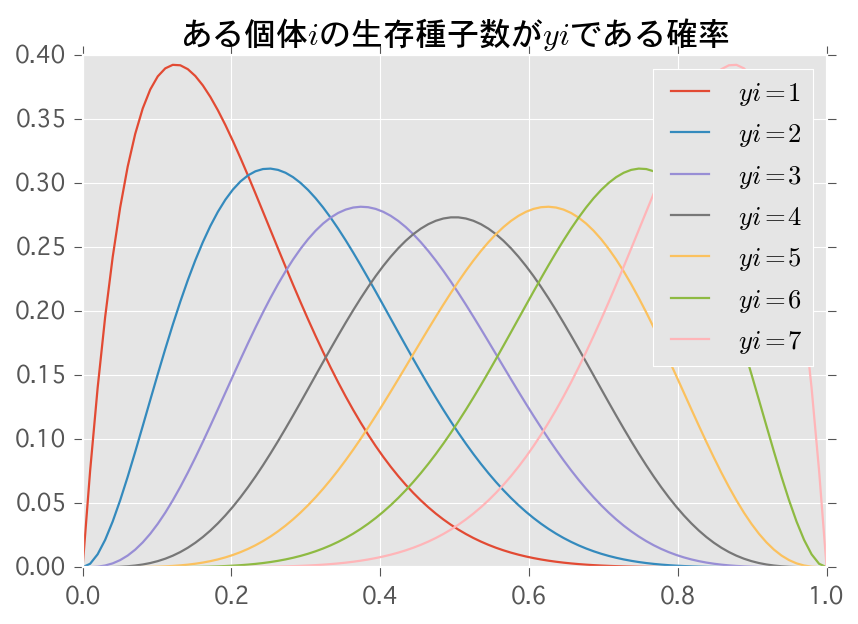

In [5]:
q = np.linspace(0, 1, 100)
plt.plot(q, p_y_given_q(q, 1))
plt.plot(q, p_y_given_q(q, 2))
plt.plot(q, p_y_given_q(q, 3))
plt.plot(q, p_y_given_q(q, 4))
plt.plot(q, p_y_given_q(q, 5))
plt.plot(q, p_y_given_q(q, 6))
plt.plot(q, p_y_given_q(q, 7))
plt.legend(['$yi=1$','$yi=2$','$yi=3$','$yi=4$','$yi=5$','$yi=6$','$yi=7$'])
plt.title(u'ある個体$i$の生存種子数が$yi$である確率')

尤度 $L(q)$ は20個体ぶんの「データが得られる確率」の積

$\displaystyle
L(q) = p(Y|q) = \Pi_{i}p(yi|q)$

In [6]:
def likelifood(q, y):
    return np.prod([scipy.misc.comb(8, yi) * (q**yi) * (1-q)**(8-yi) for yi in y])

def calc_likelifood(X, y):
    return [likelifood(x, y) for x in X]

def log_likelifood(q, y):
    return sum([yi * np.log(q) + (8-yi)*np.log(1-q) for yi in y]) + 1

def calc_log_likelifood(X, y):
    return [log_likelifood(x, y) for x in X]

In [7]:
X = np.linspace(0.01, 0.99, 100)
l = calc_likelifood(X, y)
log_l = calc_log_likelifood(X, y)

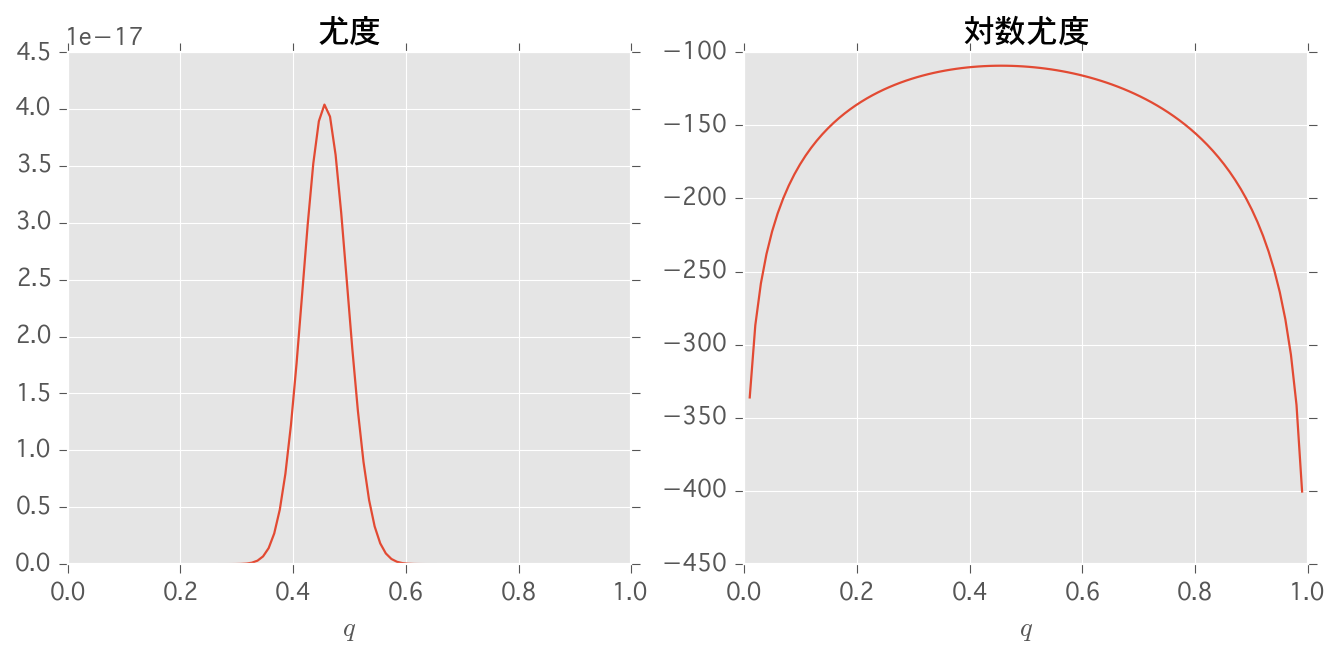

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(X, l)
ax[0].set_title(u'尤度')
ax[0].set_xlabel(u'$q$')
ax[1].plot(X, log_l)
ax[1].set_title(u'対数尤度')
ax[1].set_xlabel(u'$q$')

$\displaystyle
\frac{dlogL(q)}{dq} = 0$ となる$\hat{q}$ を(解析的に)もとめると

0.45625 (式の展開はホワイトボードで)

## 8.2 ふらふら試行錯誤による最尤推定

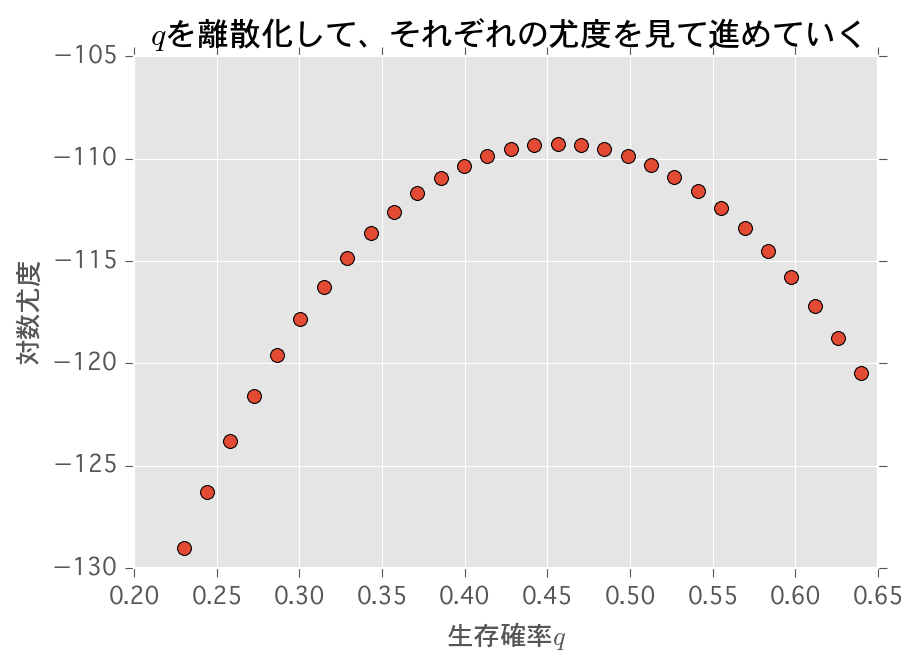

In [11]:
X = np.linspace(0.23, 0.64, 30)
l = calc_log_likelifood(X, y)
plt.plot(X, l, 'o')
plt.xlabel(u'生存確率$q$')
plt.ylabel(u'対数尤度')
plt.title(u'$q$を離散化して、それぞれの尤度を見て進めていく')

In [13]:
def naive_hill_climb(X, likelifood):
    history = []
    def next():
        return 1 if np.random.random() > 0.5 else -1
    
    def update_judge(new_likelifood, current_likelifood):
        # 尤度が上がるなら更新
        return new_likelifood > current_likelifood
        
    pos = 0
    current = likelifood[0]
    while pos <= len(likelifood):
        tmp = pos + next() # +1 or -1 ランダムで動かしてみる
        new = likelifood[tmp]
        history.append(X[tmp])
        if update_judge(new, current):
            pos = tmp
            if np.abs(new - current) < 0.05:
                break # 変化しなくなったら終了
            current = new
    return X[pos], history

X = np.linspace(0.1, 0.9, 100)
l = calc_log_likelifood(X, y)
m, history = naive_hill_climb(X, l)

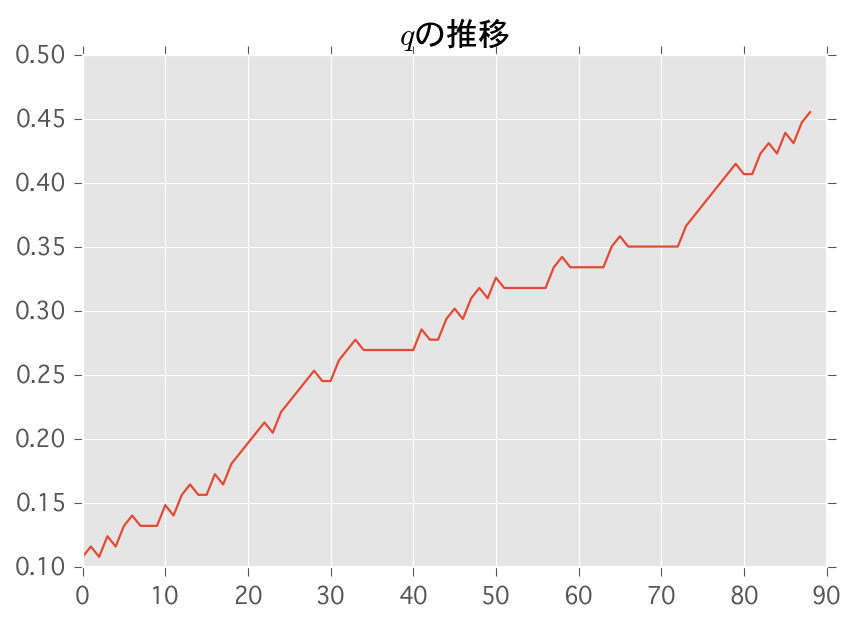

In [16]:
plt.plot(history)
plt.title(u'$q$の推移')

## 8.3 MCMCアルゴリズムのひとつ：メトロポリス法

In [17]:
def metropolis(X, likelifoods, step):
    history = []
    def next():
        return 1 if np.random.random() > 0.5 else -1
    
    def update_judge(new_likelifood, current_likelifood):
        # 尤度比を使って動かす
        l_rate = np.exp(new_likelifood - current_likelifood)
        return np.random.random() < l_rate
        
    pos = 10
    current = likelifoods[pos]
    t = 0
    while t < step:
        tmp = np.abs(pos + next()) # +1 or -1 ランダムで動かしてみる
        new = likelifoods[tmp]
        history.append(X[pos])
        if update_judge(new, current):
            pos = tmp
            current = new
        t += 1
    return history

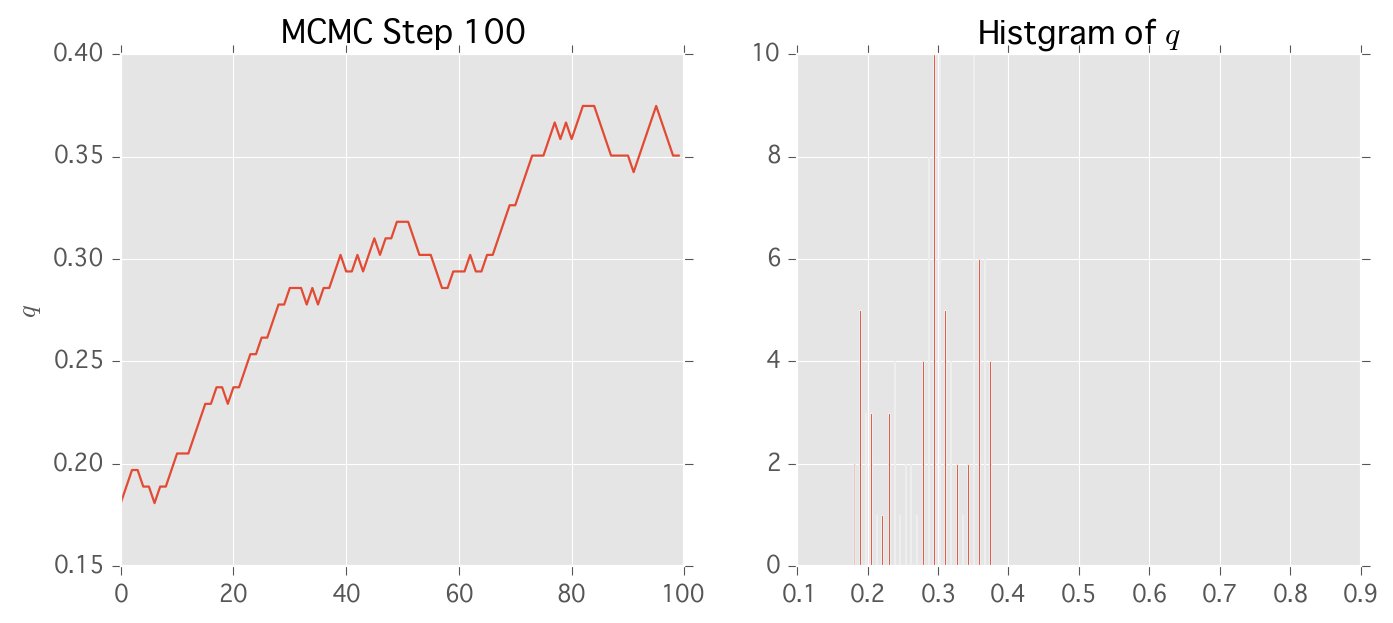

In [23]:
X = np.linspace(0.1, 0.9, 100)
l = calc_log_likelifood(X, y)
ret = metropolis(X, l, 100)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(ret)
ax[0].set_title(u'MCMC Step 100')
ax[0].set_ylabel('$q$')
ax[1].hist(ret, bins=100)
ax[1].set_xlim(0.1, 0.9)
ax[1].set_title(u'Histgram of $q$')


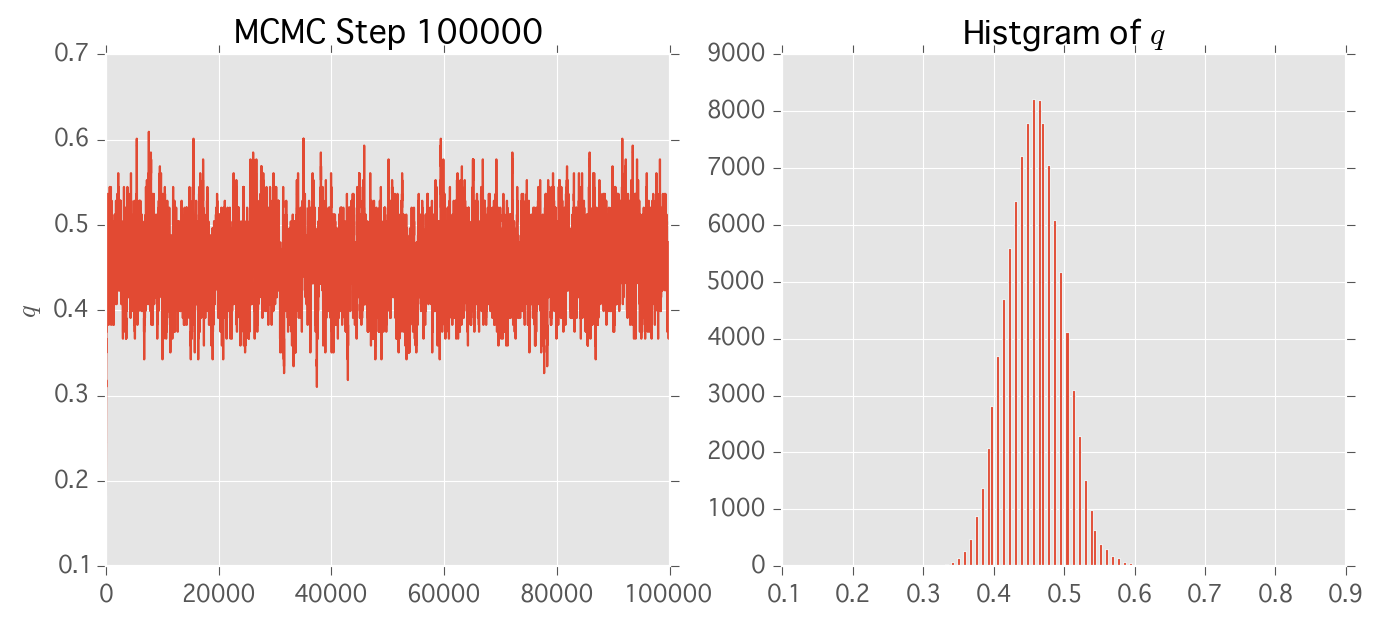

In [22]:
X = np.linspace(0.1, 0.9, 100)
l = calc_log_likelifood(X, y)
ret = metropolis(X, l, 100000)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(ret)
ax[0].set_title('MCMC Step 100000')
ax[0].set_ylabel('$q$')
ax[1].hist(ret, bins=100)
ax[1].set_xlim(0.1, 0.9)
ax[1].set_title(u'Histgram of $q$')


## 定常分布

これは何? → $p(q|Y)$は尤度$L(q)$に比例する確率分布

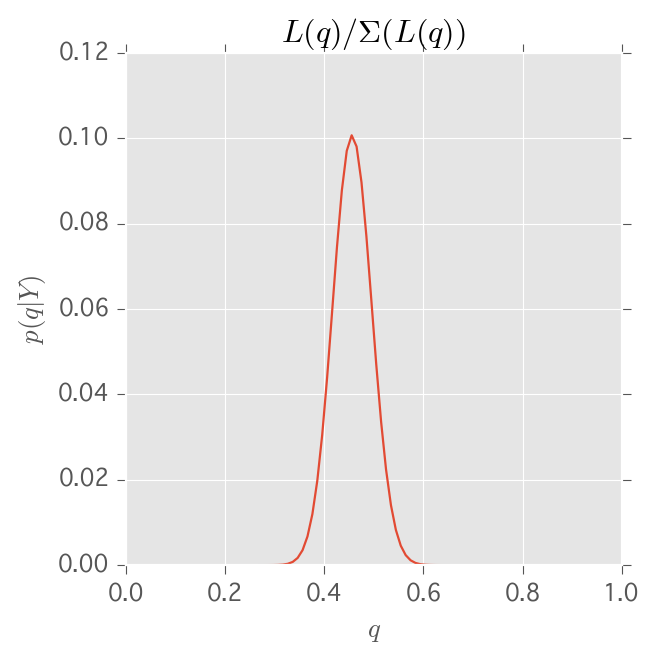

In [37]:
fig = plt.figure(figsize=(4, 4))
plot = fig.add_subplot(1, 1, 1)
X = np.linspace(0.01, 0.99, 100)
l = calc_likelifood(X, y)
plot.plot(X, l/sum(l))
plt.ylabel('$p(q|Y)$')
plt.title('$L(q)/\Sigma(L(q))$')
plt.xlabel('$q$')

MCMCサンプリングとは何だったのか

- ランダムサンプルを得るのが目的、最も尤度が高い点を求めるのでは無い
- 定常分布を求めて、データ$Y$に統計モデルをあてはめた時のパラメータの確率分布を得る事
- 複雑な統計モデルのあてはめで威力を発揮するらしい
  - 例として簡単なモデルが使われたので、この章ではわかりにくい気がした
  - 10章でやるっぽい

## 8.4 MCMCサンプリングとベイズ統計モデル


ベイズの話はPRMLで散々やってるのでさらっと